# MNIST digits classification with TensorFlow 2

<img src="images/mnist_sample.png" style="width:30%">

In [13]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
print("We're using TF", tf.__version__)


We're using TF 2.9.1


# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [14]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train [shape (60000, 28, 28)] sample patch:
 [[  0  76 246 252 112]
 [  0  85 252 230  25]
 [  0  85 252 223   0]
 [  0  85 252 145   0]
 [  0  86 253 225   0]]
A closeup of a sample patch:


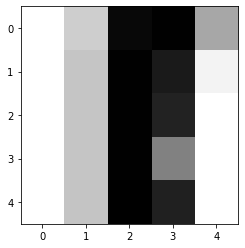

And the whole sample:


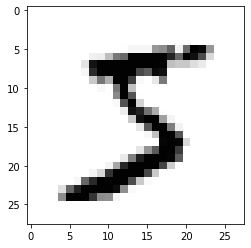

y_train [shape (60000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [15]:
print("x_train [shape %s] sample patch:\n" % (str(x_train.shape)), x_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(x_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(x_train[0], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])


In [16]:
# Normalize image values from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.


# Linear model

Our aim is to train a linear classifier $\vec{x} \rightarrow y$ with SGD (or other optimizers) using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{w_k} \cdot \vec{x} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if} \; x \; \text{is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

For our model, we can assume that $\vec{x}$ is a flattened vector coming from a digit image and $\vec{w_k}$ is a row from a weight matrix.

<img src="images/linear_classifier.png" style="width:70%">

When labels are represented by **one-hot vectors**, use the TensorFlow loss function 
```python
tf.keras.losses.CategoricalCrossentropy .
```
When labels are represented by **integers** (as in the above picture), use 
```python
tf.keras.losses.SparseCategoricalCrossentropy
```
instead.

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')])
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


2022-08-04 16:21:25.924659: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4671 - accuracy: 0.8785
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3043 - accuracy: 0.9152
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2835 - accuracy: 0.9206
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2734 - accuracy: 0.9231
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2667 - accuracy: 0.9260
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2621 - accuracy: 0.9276
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2584 - accuracy: 0.9279
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2556 - accuracy: 0.9294
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2539 - accuracy: 0.9292
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.251

In [18]:
# Compare some predicted digits with the actual digits 
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
print(predictions[:10])
print(y_test[:10])


313/313 [==============================] - 0s 968us/step
[7 2 1 0 4 1 4 9 6 9]
[7 2 1 0 4 1 4 9 5 9]


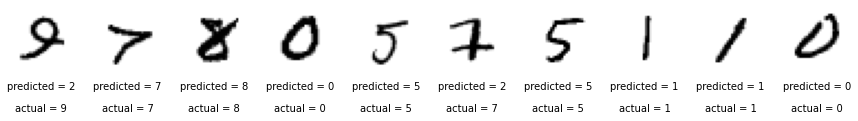

In [19]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx] 
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'predicted = ' + str(predictions[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'actual = ' + str(y_test[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='binary')


# MLP with hidden layers

We can easily build a MultiLayer Perceptron using TensorFlow's dense layer construct:
```python
tf.keras.layers.Dense(inputs, 256, activation=tf.nn.sigmoid) .
```
We now define and train a neural network with 2 hidden layers.


In [8]:
mlp_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(256, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(10)])


In [10]:
mlp_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [9]:
mlp_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
mlp_model.fit(x_train, y_train, epochs=10)


Epoch 1/10


2022-08-04 15:45:19.724834: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 7s 4ms/step - loss: 0.3617 - accuracy: 0.8959
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1505 - accuracy: 0.9545
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1009 - accuracy: 0.9690
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0729 - accuracy: 0.9772
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0552 - accuracy: 0.9826
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0422 - accuracy: 0.9865
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0319 - accuracy: 0.9896
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0241 - accuracy: 0.9926
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0196 - accuracy: 0.9939
Epoch 10/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0166 - accurac

In [12]:
predictions = mlp_model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
print(predictions[:10])
print(y_test[:10])

313/313 [==============================] - 1s 2ms/step
[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


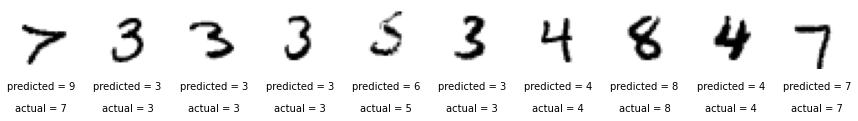

In [11]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx] 
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'predicted = ' + str(predictions[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'actual = ' + str(y_test[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='binary')
